## GNNExplainer
Graph Neural Networks (GNNs) are a powerful tool for machine learning on graphs.GNNs combine node feature information with the graph structure by recursively passing neural messages along edges of the input graph. However, incorporating both graph structure and feature information leads to complex models, and explaining predictions made by GNNs remains unsolved. 

GNNExplainer, the first general, model-agnostic approach for providing interpretable explanations for predictions of any GNN-based model on any graph-based machine learning task. Given an instance, GNNExplainer identifies a compact subgraph structure and a small subset of node features that have a crucial role in GNN's prediction. 

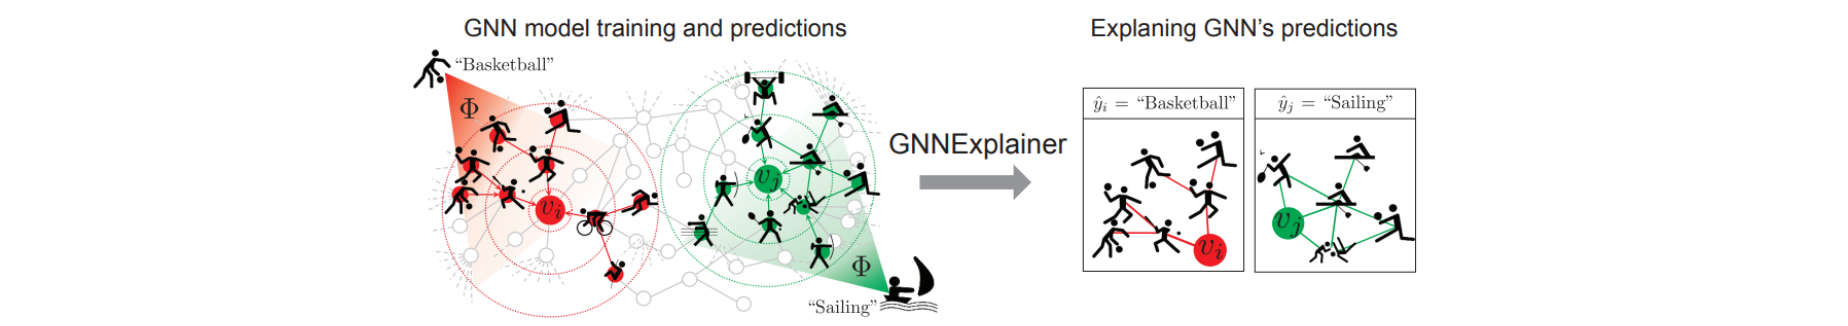

Ying Z, Bourgeois D, You J, et al. Gnnexplainer: Generating explanations for graph neural networks[J]. Advances in neural information processing systems, 2019, 32.

In [10]:
from math import sqrt
from typing import Optional
import torch
from tqdm import tqdm
from inspect import signature
from math import sqrt
from typing import Optional
import torch
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import get_num_hops, k_hop_subgraph, to_networkx

def set_masks(model: torch.nn.Module, mask: Tensor, edge_index: Tensor,
              apply_sigmoid: bool = True):
    """Apply mask to every graph layer in the model."""
    loop_mask = edge_index[0] != edge_index[1]

    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = True
            module._edge_mask = mask  
            module._loop_mask = loop_mask  
            module._apply_sigmoid = apply_sigmoid


def clear_masks(model: torch.nn.Module):
    """Clear all masks from the model."""
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.explain = False
            module._edge_mask = None
            module._loop_mask = None
            module._apply_sigmoid = True
    return module


class CaptumModel(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, mask_type: str = "edge",
                 output_idx: Optional[int] = None):
        super().__init__()
        assert mask_type in ['edge', 'node', 'node_and_edge']

        self.mask_type = mask_type
        self.model = model
        self.output_idx = output_idx

    def forward(self, mask, *args):
        assert mask.shape[0] == 1, "Dimension 0 of input should be 1"
        if self.mask_type == "edge":
            assert len(args) >= 2, "Expects at least x and edge_index as args."
        if self.mask_type == "node":
            assert len(args) >= 1, "Expects at least edge_index as args."
        if self.mask_type == "node_and_edge":
            assert args[0].shape[0] == 1, "Dimension 0 of input should be 1"
            assert len(args[1:]) >= 1, "Expects at least edge_index as args."

        # Set edge mask:
        if self.mask_type == 'edge':
            set_masks(self.model, mask.squeeze(0), args[1],
                      apply_sigmoid=False)
        elif self.mask_type == 'node_and_edge':
            set_masks(self.model, args[0].squeeze(0), args[1],
                      apply_sigmoid=False)
            args = args[1:]

        if self.mask_type == 'edge':
            x = self.model(*args)

        elif self.mask_type == 'node':
            x = self.model(mask.squeeze(0), *args)

        else:
            x = self.model(mask[0], *args)

        # Clear mask:
        if self.mask_type in ['edge', 'node_and_edge']:
            clear_masks(self.model)

        if self.output_idx is not None:
            x = x[self.output_idx].unsqueeze(0)

        return x


def to_captum(model: torch.nn.Module, mask_type: str = "edge",
              output_idx: Optional[int] = None) -> torch.nn.Module:

    return CaptumModel(model, mask_type, output_idx)


class Explainer(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, lr: Optional[float] = None,
                 epochs: Optional[int] = None, num_hops: Optional[int] = None,
                 return_type: str = 'log_prob', log: bool = False):
        super().__init__()
        assert return_type in ['log_prob', 'prob', 'raw', 'regression']

        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.num_hops = num_hops or get_num_hops(self.model)
        self.return_type = return_type
        self.log = log

    def _flow(self) -> str:
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def subgraph(self, node_idx: int, x: Tensor, edge_index: Tensor, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self._flow())

        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            else:
                kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new

    def _to_log_prob(self, x):
        x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
        x = x.log() if self.return_type == 'prob' else x
        return x

    @torch.no_grad()
    def get_initial_prediction(self, x: Tensor, edge_index: Tensor,
                    h_V ,h_E, seq,
                    feature_molecule,
                    picdata,batch: Optional[Tensor] = None, **kwargs):
        if batch is not None:
            out = self.model(
                    h_V[0],h_V[1] ,edge_index,h_E, seq,batch,
                    feature_molecule,
                    picdata)
        else:
            out = self.model(h_V ,edge_index,h_E, seq,batch,
                    feature_molecule,
                    picdata)
        if self.return_type == 'regression':
            prediction = out
        else:
            log_logits = self._to_log_prob(out)
            prediction = log_logits.argmax(dim=-1)
        return prediction

    def get_loss(self, out: Tensor, prediction: Tensor,
                 node_idx: Optional[int] = None, **kwargs):
        if self.return_type == 'regression':
            loss = self._loss(out, prediction, node_idx, **kwargs)
        else:
            log_logits = self._to_log_prob(out)
            loss = self._loss(log_logits, prediction, node_idx, **kwargs)
        return loss

    def visualize_subgraph(self, node_idx: Optional[int], edge_index: Tensor,
                           edge_mask: Tensor, y: Optional[Tensor] = None,strr = None,
                           threshold: Optional[int] = None,
                           edge_y: Optional[Tensor] = None,
                           node_alpha: Optional[Tensor] = None, seed: int = 10,
                           **kwargs):

        import matplotlib.pyplot as plt
        import networkx as nx

        assert edge_mask.size(0) == edge_index.size(1)

        if node_idx is None or node_idx < 0:
            # hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
            #                                   device=edge_mask.device)
            hard_edge_mask = torch.tensor([True] * edge_index.size(1),
                                              device=edge_mask.device)
            hard_edge_mask = hard_edge_mask.bool()
            subset = torch.arange(edge_index.max().item() + 1,
                                  device=edge_index.device)
            y = None

        else:
            # Only operate on a k-hop subgraph around `node_idx`.
            subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
                node_idx, self.num_hops, edge_index, relabel_nodes=True,
                num_nodes=None, flow=self._flow())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        if edge_y is None:
            edge_color = ['black'] * edge_index.size(1)
        else:
            colors = list(plt.rcParams['axes.prop_cycle'])
            edge_color = [
                colors[i % len(colors)]['color']
                for i in edge_y[hard_edge_mask]
            ]

        data = Data(edge_index=edge_index, att=edge_mask,
                    edge_color=edge_color, y=y, num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'],
                        edge_attrs=['att', 'edge_color'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_args = set(signature(nx.draw_networkx_nodes).parameters.keys())
        node_kwargs = {k: v for k, v in kwargs.items() if k in node_args}
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_args = set(signature(nx.draw_networkx_labels).parameters.keys())
        label_kwargs = {k: v for k, v in kwargs.items() if k in label_args}
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G, seed=seed)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    color=data['edge_color'],
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))

        if node_alpha is None:
            nx.draw_networkx_nodes(G, pos, node_color=y.tolist(),
                                   **node_kwargs)
        else:
            node_alpha_subset = node_alpha[subset]
            assert ((node_alpha_subset >= 0) & (node_alpha_subset <= 1)).all()
            nx.draw_networkx_nodes(G, pos, alpha=node_alpha_subset.tolist(),
                                   node_color=y.tolist(), **node_kwargs)

        nx.draw_networkx_labels(G, pos, **label_kwargs)
        plt.show()
        plt.close()

        return ax, G


EPS = 1e-15


class GNNExplainer(Explainer):

    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 feat_mask_type: str = 'feature', allow_edge_mask: bool = True,
                 log: bool = True, **kwargs):
        super().__init__(model, lr, epochs, num_hops, return_type, log)
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']
        self.allow_edge_mask = allow_edge_mask
        self.feat_mask_type = feat_mask_type
        self.coeffs.update(kwargs)


    def _initialize_masks(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1

        if self.feat_mask_type == 'individual_feature':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        elif self.feat_mask_type == 'scalar':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        else:
            self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

    def _clear_masks(self):
        clear_masks(self.model)
        self.node_feat_masks = None
        self.edge_mask = None

    def _loss(self, log_logits, prediction, node_idx: Optional[int] = None):
        if self.return_type == 'regression':
            if node_idx is not None and node_idx >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_graph(self, x,y, edge_index,
                    h_V ,h_E, seq,
                    feature_molecule,
                    picdata,**kwargs):

        self.model.eval()
        self._clear_masks()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index,
                    h_V ,h_E, seq,
                    feature_molecule,
                    picdata, batch=batch,**kwargs)

        self._initialize_masks(x, edge_index) 
        self.to(x.device)
        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask] 
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h1 = h_V[0] * self.node_feat_mask.sigmoid()
            
            out = self.model(h1, h_V[1],edge_index,h_E, seq,batch,
                    feature_molecule,
                    picdata)
            loss = self.get_loss(out, prediction, None)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid().squeeze()
        if self.allow_edge_mask:
            edge_mask = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.ones(edge_index.size(1))

        self._clear_masks()
        return node_feat_mask, edge_mask

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.subgraph(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

    def __repr__(self):
        return f'{self.__class__.__name__}()'

def pic(model,data,device):
    #Explain the Graph
    explainer = GNNExplainer(model, epochs=100,return_type='log_prob')
    # data = data.to(device)
    h_V = (torch.tensor(data["node_s"]), torch.tensor(data["node_v"]))
    h_E = (torch.tensor(data["edge_s"]), torch.tensor(data["edge_v"]))

    node_feat_mask, edge_mask = explainer.explain_graph(x=h_V[0],y = h_V[1],edge_index = torch.tensor(data["edge_index"]), 
                                                        h_V = h_V,h_E = h_E, seq=torch.tensor(data["seq"]),
                                                        feature_molecule=torch.tensor(data["feature_molecule"]),
                                                        picdata = torch.tensor(data["picdata"]))
    ax, G = explainer.visualize_subgraph(-1,torch.tensor(data["edge_index"]), edge_mask)

Here is a demo.

Explain graph: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


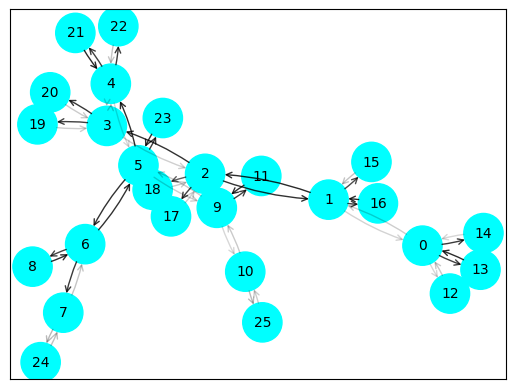

In [12]:
import json
import gvp.MSCSolmodel
import warnings
warnings.filterwarnings("ignore")
with open('./pic/GNNExplainer_demo.json', 'r') as json_file:
    data = json.load(json_file)

node_dim = (100, 16)
edge_dim = (32, 1)
device = torch.device("cpu")
model = gvp.MSCSolmodel.Model((7, 2), node_dim, (32, 1), edge_dim).to(device)
model.load_state_dict(torch.load('./pic/GNNEx.pt'))
pic(model,data,device)